## Sometimes the frame count does not match the number of sync pulses
<br>We observe two errors: too many frames OR too few frames.
<br>
<br>If there are too many frames, we can compare the native timestamps (from the .h5 file) to the sync timestamps to find where in the recording the mismatch happens (it is usually in the middle of the recording). Then we can correct the mismatch by removing the extra frames then aligning with the sync clock. Use the below code to do so.
<br>
<br>If there are missing frames, the number of native timestamps is actually equal to the number of sync timestamps. So the video itself is missing frames even though it has timestamps for them. I don't yet know how to correctly align in this case. For now we can delete the first few sync timestamps to match the lengths. So far in our recordings, this type of mismatch only occurs for a small number of frames (< 16 so far).

In [1]:
import h5py
import os
import sys

import cv2
import gspread
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from allensdk.brain_observatory.sync_dataset import Dataset

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.behavior_movies import Movie, get_sync_frame_times

In [4]:
%matplotlib widget

# Fix one subject

iloc[21]: 669117 (pilot_ur) has 114 extra frames
<br>iloc[25]: 676726 (aw_psi) frames = sync (NO weird clock shifts)
<br>iloc[34]: 698242 (aw_psi) has 26 extra frames (clock shift in middle of recording)

In [5]:
recdir = r"P:\mouse771427\THstim_d1_2025-01-22_10-36-51\experiment1\recording1"
exp = EEGexp(recdir, preprocess=False, make_stim_csv=False)
sync_data = exp._load_sync_dataset()

Experiment type: electrical stimulation


In [6]:
pupilmovie = Movie(filepath=exp.pupilmovie_file, sync_filepath=exp.sync_file, sync_channel='eyetracking')
print('Pupil frame count = {:d}'.format(pupilmovie.frame_count))
print('Pupil sync timestamps = {:d}'.format(len(pupilmovie.sync_timestamps)))

Pupil frame count = 159889
Pupil sync timestamps = 159862


C:\Users\lesliec\code\tbd_eeg\tbd_eeg\data_analysis\Utilities\behavior_movies.py:40: UserWarning: NONMATCHING timestamp counts
There are 159862 timestamps in sync and 159889 timestamps in the associated camera file
these should match
  warnings.warn(f'NONMATCHING timestamp counts\nThere are {len(self.sync_timestamps)} timestamps in sync and {len(self.timestamps_from_file)} timestamps in the associated camera file\nthese should match' )


In [7]:
pupilvid = cv2.VideoCapture(exp.pupilmovie_file)
print('Pupil frame count = {:d}'.format(int(pupilvid.get(cv2.CAP_PROP_FRAME_COUNT))))
pupilsync = sync_data.get_edges(keys=('eyetracking',), kind='rising', units='seconds')
print('Pupil sync count = {:d}'.format(len(pupilsync)))
print('Extra frames = {:d}'.format(int(pupilvid.get(cv2.CAP_PROP_FRAME_COUNT)) - len(pupilsync)))

Pupil frame count = 159889
Pupil sync count = 159862
Extra frames = 27


In [8]:
bodyvid = cv2.VideoCapture(exp.bodymovie_file)
print('Body frame count = {:d}'.format(int(bodyvid.get(cv2.CAP_PROP_FRAME_COUNT))))
bodysync = sync_data.get_edges(keys=('behavior',), kind='rising', units='seconds')
print('Body sync count = {:d}'.format(len(bodysync)))
print('Extra frames = {:d}'.format(int(bodyvid.get(cv2.CAP_PROP_FRAME_COUNT)) - len(bodysync)))

Body frame count = 318681
Body sync count = 318628
Extra frames = 53


### Investigate sync time intervals and frame time intervals

In [9]:
## Load native frame times ##
pupilh5 = h5py.File(exp.pupilmovie_file.replace('.avi','.h5'), 'r')
pupil_ts = np.hstack((0, np.cumsum(pupilh5['frame_intervals'])))

## Load falling edges, intervals between falling edges match frame intervals better ##
pfalling = sync_data.get_edges(keys=('eyetracking',), kind='falling', units='seconds')

In [10]:
print('Pupil frame count = {:d}'.format(int(pupilvid.get(cv2.CAP_PROP_FRAME_COUNT))))
print('Pupil timestamp count = {:d}'.format(len(pupil_ts)))
print('Pupil sync falling edges = {:d}'.format(len(pfalling)))

Pupil frame count = 159889
Pupil timestamp count = 159889
Pupil sync falling edges = 159862


### Some intervals are longer than expected. Do they align?

tt represents a duration (s). Here we are looking for frame intervals that are shorter than the standard frame rate (0.03 s). Change tt to some value smaller than the frame rate to find which indices match/do not match.

In [1]:
tt = 0.025
print(np.nonzero(np.diff(pupil_ts) < tt)[0])
print(np.nonzero(np.diff(pfalling) < tt)[0])

NameError: name 'np' is not defined

### Choose the indices window around which you suspect the jump.

698242 (aw_psi) = [163165, 163205]
<br> 669117 (pilot_ur) = [139239, 144605]
<br> 689329 (aw_psi) = [61009, 61280]
<br> 735051 (aw_sal) = [39709, 39949]
<br> 771425 (THstim_d2) = [150500, 151000]
<br> 771427 (THstim_d1) = [150700, 151000]

In [13]:
indwins = [150700, 151000]

(0.0, 159862.0)

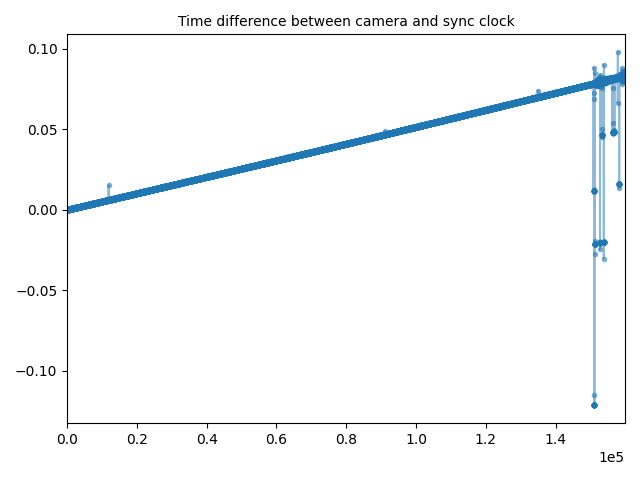

In [14]:
fig, ax = plt.subplots(tight_layout=True)
timediff = (pupil_ts[:len(pfalling)] - pupil_ts[0]) - (pfalling - pfalling[0])
ax.plot(timediff, marker='.', alpha=0.5)
ax.set_title('Time difference between camera and sync clock')
# ax.axvline(indwins[0], color='r', alpha=0.5)
# ax.axvline(indwins[1], color='r', alpha=0.5)
ax.set_xlim(0, len(pfalling))

### Remove extra frame times

698242: 163199
<br> 669117: 143986
<br> 689239: 61152
<br> 720762ket: 138068
<br> 735051aw_sal: 39775
<br> 771425THstim_d2: 150900
<br> 771427THstim_d2: 150900

In [15]:
messind = 150850

if len(pupil_ts) > len(pupilsync):
    num_frames = len(pupil_ts) - len(pupilsync)
    print('There are {:d} extra frames...deleting them.'.format(num_frames))
    new_ts = np.delete(pupil_ts, np.arange(messind, messind+num_frames))
elif len(pupil_ts) < len(pupilsync):
    num_syncs = len(pupilsync) - len(pupil_ts)
    print('There are {:d} extra sync pulses...deleting the extras from the end.'.format(num_syncs))
    new_sync = pupilsync[:len(pupil_ts)]

There are 27 extra frames...deleting them.


#### Test it

(0.0, 159862.0)

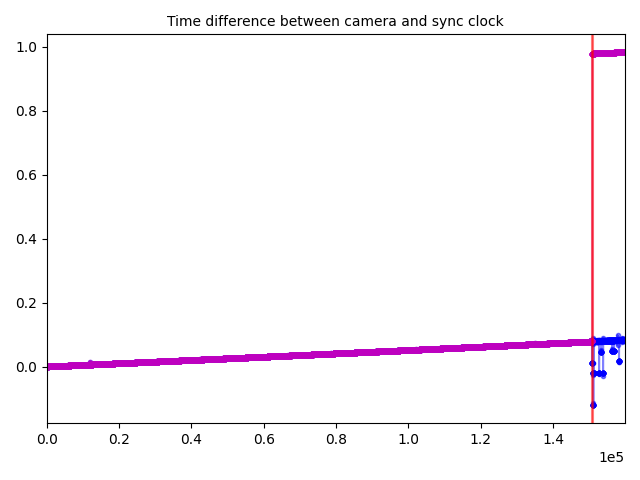

In [16]:
fig, ax = plt.subplots(tight_layout=True)
timediff = (pupil_ts[:len(pfalling)] - pupil_ts[0]) - (pfalling - pfalling[0])
newtimediff = (new_ts - new_ts[0]) - (pfalling - pfalling[0])
ax.plot(timediff, marker='.', color='b', alpha=0.5)
ax.plot(newtimediff, marker='.', color='m', alpha=0.5)
ax.set_title('Time difference between camera and sync clock')
ax.axvline(indwins[0], color='r', alpha=0.5)
ax.axvline(indwins[1], color='r', alpha=0.5)
ax.set_xlim(0, len(pfalling))

### Looks good, now remove frames from pupil .csv

In [17]:
print('Pupil frame count = {:d}'.format(int(pupilvid.get(cv2.CAP_PROP_FRAME_COUNT))))
print('Pupil sync count = {:d}'.format(len(pupilsync)))

Pupil frame count = 159889
Pupil sync count = 159862


In [18]:
files = os.listdir(exp.data_folder)
pupil_file = exp.data_folder + '/' + next(file for file in files if file.split('_')[0] == 'Pupileye')
print(pupil_file)

P:\mouse771427\THstim_d1_2025-01-22_10-36-51\experiment1\recording1/Pupileye_THstim_d1_2025-01-22_10-36-51.csv


In [19]:
pupil_data = pd.read_csv(pupil_file)
print(len(pupil_data))
pupil_data.head()

159889


,Time_Frames,X_Position,Y_Position,Radius_1,Radius_2,Angle,Largest_Radius,Eye_Diameter,sync_time
0,0.0,271.835424,241.999898,49.153124,45.375207,0.350762,49.153124,355.202706,NaN
1,1.0,271.812288,242.081350,49.252990,45.443808,0.343365,49.252990,355.294295,NaN
2,2.0,271.378702,242.138356,49.157006,45.276890,0.371851,49.157006,355.014701,NaN
3,3.0,271.265583,242.333540,49.091088,45.071046,0.381398,49.091088,355.161228,NaN
4,4.0,271.215043,242.057952,49.019427,44.954642,0.387681,49.019427,355.226637,NaN


In [20]:
corrected_pupil_data = pupil_data.drop(labels=np.arange(messind, messind+num_frames), axis=0)
print(len(corrected_pupil_data))

159862


In [21]:
corrected_pupil_data['sync_time'] = pupilsync
corrected_pupil_data.head()

,Time_Frames,X_Position,Y_Position,Radius_1,Radius_2,Angle,Largest_Radius,Eye_Diameter,sync_time
0,0.0,271.835424,241.999898,49.153124,45.375207,0.350762,49.153124,355.202706,18.76321
1,1.0,271.812288,242.081350,49.252990,45.443808,0.343365,49.252990,355.294295,18.78736
2,2.0,271.378702,242.138356,49.157006,45.276890,0.371851,49.157006,355.014701,18.78929
3,3.0,271.265583,242.333540,49.091088,45.071046,0.381398,49.091088,355.161228,18.81793
4,4.0,271.215043,242.057952,49.019427,44.954642,0.387681,49.019427,355.226637,18.85121


In [22]:
pupil_data.tail()

,Time_Frames,X_Position,Y_Position,Radius_1,Radius_2,Angle,Largest_Radius,Eye_Diameter,sync_time
159884,159884.0,290.741412,233.863660,30.751368,25.501242,0.342642,30.751368,355.981228,NaN
159885,159885.0,290.865642,233.945988,30.528395,25.508260,0.352551,30.528395,356.209436,NaN
159886,159886.0,290.883815,233.991870,30.434721,25.375333,0.356033,30.434721,356.382816,NaN
159887,159887.0,290.743109,234.011967,30.378803,25.383005,0.365666,30.378803,356.420944,NaN
159888,159888.0,290.800541,233.921941,30.443669,25.318006,0.347208,30.443669,355.728227,NaN


In [23]:
corrected_pupil_data.tail()

,Time_Frames,X_Position,Y_Position,Radius_1,Radius_2,Angle,Largest_Radius,Eye_Diameter,sync_time
159884,159884.0,290.741412,233.863660,30.751368,25.501242,0.342642,30.751368,355.981228,5352.29287
159885,159885.0,290.865642,233.945988,30.528395,25.508260,0.352551,30.528395,356.209436,5352.32663
159886,159886.0,290.883815,233.991870,30.434721,25.375333,0.356033,30.434721,356.382816,5352.35976
159887,159887.0,290.743109,234.011967,30.378803,25.383005,0.365666,30.378803,356.420944,5352.39288
159888,159888.0,290.800541,233.921941,30.443669,25.318006,0.347208,30.443669,355.728227,5352.42757


## Now save pupil .csv with aligned timestamps

In [24]:
corrected_pupil_data.to_csv(pupil_file, index=False)

# Check a list of mice to find mismatches

Get Templeton log for experiment list

Check all subjects for sync mismatches

# Test sync times with one subject

iloc[21]: 669117 (pilot_ur) has 114 extra frames
<br>iloc[25]: 676726 (aw_psi) frames = sync (NO weird clock shifts)
<br>iloc[34]: 698242 (aw_psi) has 26 extra frames (clock shift in middle of recording)

In [ ]:
recdir = r"P:\mouse771427\THstim_d1_2025-01-22_10-36-51\experiment1\recording1"
exp = EEGexp(recdir, preprocess=False, make_stim_csv=False)
sync_data = exp._load_sync_dataset()

In [ ]:
pupilmovie = Movie(filepath=exp.pupilmovie_file, sync_filepath=exp.sync_file, sync_channel='eyetracking')
print('Pupil frame count = {:d}'.format(pupilmovie.frame_count))
print('Pupil sync timestamps = {:d}'.format(len(pupilmovie.sync_timestamps)))

In [ ]:
pupilvid = cv2.VideoCapture(exp.pupilmovie_file)
print('Pupil frame count = {:d}'.format(int(pupilvid.get(cv2.CAP_PROP_FRAME_COUNT))))
pupilsync = sync_data.get_edges(keys=('eyetracking',), kind='rising', units='seconds')
print('Pupil sync count = {:d}'.format(len(pupilsync)))
print('Extra frames = {:d}'.format(int(pupilvid.get(cv2.CAP_PROP_FRAME_COUNT)) - len(pupilsync)))

In [ ]:
bodyvid = cv2.VideoCapture(exp.bodymovie_file)
print('Body frame count = {:d}'.format(int(bodyvid.get(cv2.CAP_PROP_FRAME_COUNT))))
bodysync = sync_data.get_edges(keys=('behavior',), kind='rising', units='seconds')
print('Body sync count = {:d}'.format(len(bodysync)))
print('Extra frames = {:d}'.format(int(bodyvid.get(cv2.CAP_PROP_FRAME_COUNT)) - len(bodysync)))

### Investigate sync time intervals and frame time intervals

In [ ]:
## Load native frame times ##
pupilh5 = h5py.File(exp.pupilmovie_file.replace('.avi','.h5'), 'r')
pupil_ts = np.hstack((0, np.cumsum(pupilh5['frame_intervals'])))

## Load falling edges, intervals between falling edges match frame intervals better ##
pfalling = sync_data.get_edges(keys=('eyetracking',), kind='falling', units='seconds')

In [ ]:
print('Pupil frame count = {:d}'.format(int(pupilvid.get(cv2.CAP_PROP_FRAME_COUNT))))
print('Pupil timestamp count = {:d}'.format(len(pupil_ts)))
print('Pupil sync falling edges = {:d}'.format(len(pfalling)))

### Some intervals are longer than expected. Do they align?

In [ ]:
tt = 0.02
print(np.nonzero(np.diff(pupil_ts) < tt)[0])
print(np.nonzero(np.diff(pfalling) < tt)[0])

In [ ]:
tt = 0.06
print(np.nonzero(np.diff(pupil_ts) > tt)[0])
print(np.nonzero(np.diff(pfalling) > tt)[0])

698242 (aw_psi) = [163165, 163205]
<br> 669117 (pilot_ur) = [139239, 144605]
<br> 689329 (aw_psi) = [61009, 61280]
<br> 735051 (aw_sal) = [39709, 39949]
<br> 771425 (THstim_d2) = [150500, 151000]
<br> 771427 (THstim_d1) = [150700, 151000]

In [ ]:
indwins = [150700, 151000]

In [ ]:
fig, ax = plt.subplots(tight_layout=True)
timediff = (pupil_ts[:len(pfalling)] - pupil_ts[0]) - (pfalling - pfalling[0])
ax.plot(timediff, marker='.', alpha=0.5)
ax.set_title('Time difference between camera and sync clock')
# ax.axvline(indwins[0], color='r', alpha=0.5)
# ax.axvline(indwins[1], color='r', alpha=0.5)
ax.set_xlim(0, len(pfalling))

### Remove extra frame times

In [ ]:
len(pupil_ts)

In [ ]:
len(pupilsync)

698242-163199, 669117-143986, 689239-61152, 720762ket-138068, 735051aw_sal-39775, 771425THstim_d2-150900

In [ ]:
messind = 150850

if len(pupil_ts) > len(pupilsync):
    num_frames = len(pupil_ts) - len(pupilsync)
    print('There are {:d} extra frames...deleting them.'.format(num_frames))
    new_ts = np.delete(pupil_ts, np.arange(messind, messind+num_frames))
elif len(pupil_ts) < len(pupilsync):
    num_syncs = len(pupilsync) - len(pupil_ts)
    print('There are {:d} extra sync pulses...deleting the extras from the end.'.format(num_syncs))
    new_sync = pupilsync[:len(pupil_ts)]

Test it

In [ ]:
fig, ax = plt.subplots(tight_layout=True)
timediff = (pupil_ts[:len(pfalling)] - pupil_ts[0]) - (pfalling - pfalling[0])
newtimediff = (new_ts - new_ts[0]) - (pfalling - pfalling[0])
ax.plot(timediff, marker='.', color='b', alpha=0.5)
ax.plot(newtimediff, marker='.', color='m', alpha=0.5)
ax.set_title('Time difference between camera and sync clock')
ax.axvline(indwins[0], color='r', alpha=0.5)
ax.axvline(indwins[1], color='r', alpha=0.5)
ax.set_xlim(0, len(pfalling))

### Remove frames from pupil .csv

In [ ]:
print('Pupil frame count = {:d}'.format(int(pupilvid.get(cv2.CAP_PROP_FRAME_COUNT))))
print('Pupil sync count = {:d}'.format(len(pupilsync)))

In [ ]:
files = os.listdir(exp.data_folder)
pupil_file = exp.data_folder + '/' + next(file for file in files if file.split('_')[0] == 'Pupileye')
print(pupil_file)

In [ ]:
pupil_data = pd.read_csv(pupil_file)
print(len(pupil_data))
pupil_data.head()

In [ ]:
corrected_pupil_data = pupil_data.drop(labels=np.arange(messind, messind+num_frames), axis=0)
print(len(corrected_pupil_data))

In [ ]:
corrected_pupil_data['sync_time'] = pupilsync
corrected_pupil_data.head()

In [ ]:
pupil_data.tail()

In [ ]:
corrected_pupil_data.tail()

## Now save pupil .csv with aligned timestamps

In [ ]:
corrected_pupil_data.to_csv(pupil_file, index=False)

# Test detrending the line
<br> Doesn't quite work as well as I hoped

In [ ]:
slope = np.mean(np.diff(timediff[:indwins[0]]))
detrend_timediff = timediff - slope*np.arange(len(timediff))

In [ ]:
fig, ax = plt.subplots(tight_layout=True)
timediff = (pupil_ts[:len(pfalling)] - pupil_ts[0]) - (pfalling - pfalling[0])
ax.plot(timediff, marker='.', color='b', alpha=0.5)
ax.plot(detrend_timediff, marker='.', color='c', alpha=0.5)
ax.set_title('Time difference between camera and sync clock')
ax.axvline(indwins[0], color='r', alpha=0.5)
ax.axvline(indwins[1], color='r', alpha=0.5)
ax.set_xlim(0, len(pfalling))

In [ ]:
avgdt = np.mean(detrend_timediff[:indwins[0]])
print(avgdt)
stddt = np.std(detrend_timediff[:indwins[0]])
print(stddt)

In [ ]:
fig, ax = plt.subplots(tight_layout=True)
timediff = (pupil_ts[:len(pfalling)] - pupil_ts[0]) - (pfalling - pfalling[0])
# ax.plot(timediff, marker='.', color='b', alpha=0.5)
ax.plot(detrend_timediff, marker='.', color='c', alpha=0.5)
ax.set_title('Time difference between camera and sync clock')
ax.axvline(indwins[0], color='r', alpha=0.5)
ax.axvline(indwins[1], color='r', alpha=0.5)
ax.axhline(avgdt + 2*stddt, color='m', alpha=0.5)
ax.axhline(avgdt - 2*stddt, color='m', alpha=0.5)
ax.set_xlim(0, len(pfalling))